# Model Comparison With Finance Data
This notebook demonstrates how to run the prediction models on financial data

In [2]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
# from src.models.DL_LSTM import build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [6]:
# load parquet data to pandas dataframe
combined_data = pd.read_parquet('../data/dataset_retail/processed/data_no_lags_s1_i1.parquet')
combined_data	= combined_data.drop(columns=['split'])
target = 'sales'

combined_data

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end
0,2013-01-01,13,2013,1,1,1,1,1,1,1,0
1,2013-01-02,11,2013,1,2,2,2,1,1,0,0
2,2013-01-03,14,2013,1,3,3,3,1,1,0,0
3,2013-01-04,13,2013,1,4,4,4,1,1,0,0
4,2013-01-05,10,2013,1,5,5,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,14,2017,12,27,2,361,52,4,0,0
1822,2017-12-28,19,2017,12,28,3,362,52,4,0,0
1823,2017-12-29,15,2017,12,29,4,363,52,4,0,0
1824,2017-12-30,27,2017,12,30,5,364,52,4,0,0


Test RMSE: 6.031
Test MSE: 36.377
Test MAE: 4.859
Test MAPE: 25.062
Test R²: 0.206
Adjusted R²: 0.204


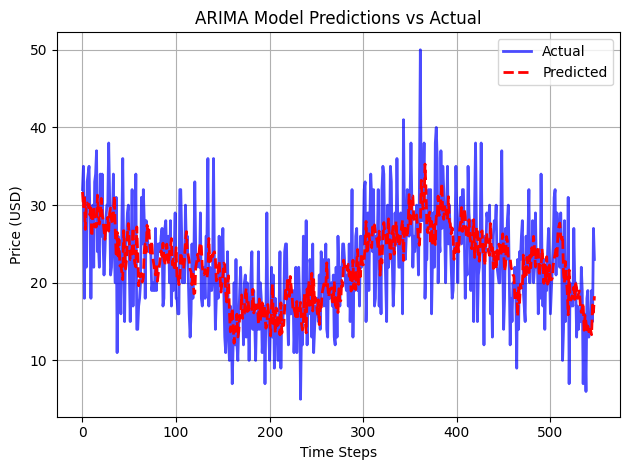

In [7]:
# ARIMA is represented by three parameters: p, d, and q:
# p: The number of past values (lags) considered in the AR term.
# d: The degree of differencing applied to the data.
# q: The number of past forecast errors included in the MA term.
# order = (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.

order = (5, 1, 0)
predictions, train, test = build_arima_model(combined_data[target], order, 0.7)

# Convert to numpy arrays (in case they're lists)
test = np.array(test)
predictions = np.array(predictions)
 
rmse, mse, mae, mape, r2, adj_r2	= generate_model_metrics(predictions, test)

# Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Mean Squared Error
# mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)

# Mean Absolute Error
# mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)

# Mean Absolute Percentage Error
# mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Test MAPE: %.3f' % mape)

# R-squared
# r2 = r2_score(test, predictions)
print('Test R²: %.3f' % r2)

# Adjusted R-squared
n = len(test)
p = 1  # number of predictors (just 1 for ARIMA by default)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('Adjusted R²: %.3f' % adj_r2)

# plot forecasts against actual outcomes
plt.plot(test, color='blue', label='Actual', linewidth=2, alpha=0.7)
plt.plot(predictions, color='red', label='Predicted', linestyle='--', linewidth=2)
plt.legend()
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
metrics_scores = {}
metrics_scores[target] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "MAPE": mape, "R2": r2, "Adj_R2": adj_r2}
metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# metrics_df.to_csv("model_metrics_scores.csv")
print(metrics_df)

           RMSE        MSE       MAE       MAPE       R2    Adj_R2
sales  6.031364  36.377347  4.859021  25.062499  0.20552  0.204065
